In [1]:
from datetime import timedelta

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import orbit
from orbit.models import DLT,ETS, KTRLite, LGT, ARMA
from orbit.utils.simulation import make_trend, make_regression
import torch
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

In [2]:
from datetime import datetime, timedelta
import datetime as dt 


In [3]:
%load_ext autoreload
%autoreload 2

<class 'numpy.ndarray'>


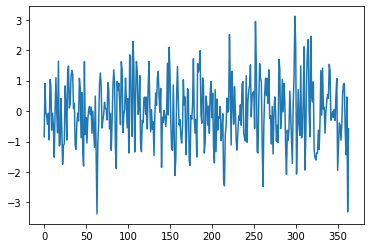

In [140]:
# make the data
n = 365 # hourly for 1 year 

x0 = np.random.normal(0, 1, n)
x1 = np.random.normal(0, 1, n)
x2 = np.random.normal(0, 1, n)
x3 = np.random.normal(0, 1, n)
x4 = np.random.normal(0, 1, n)
x5 = np.random.normal(0, 1, n)
x6 = np.random.normal(0, 1, n)
x7 = np.random.normal(0, 1, n)
x8 = np.random.normal(0, 1, n)
x9 = np.random.normal(0, 1, n)

X = np.vstack([x0, x1]).transpose()
   
    

eta = np.random.normal(0, 1.0, n)

rho = [0.40, -0.25,0.15,-0.1, 0.05]
beta = [0.00, -0.00]
y = eta.copy()
for i in range(2, n):
    #y[i] = rho[0]*y[i-1] + rho[1]*y[i-2] + rho[2]*y[i-7] + x0[i]*beta[0]+ x1[i]*beta[1]+ eta[i]
    y[i] = rho[0]*y[i-1] + rho[1]*y[i-2] + rho[2]*y[i-3]  + rho[3]*y[i-4] + rho[4]*y[i-5] + x0[i]*beta[0]+ x1[i]*beta[1]+ eta[i]

     
#plt.plot(y)
plt.plot(y[1:500])
print(type(X))

In [141]:
def daterange(start_date, end_date):
    delta = timedelta(hours=1)
    while start_date < end_date:
        yield start_date
        start_date += delta
        
hours = [datetime(2013, 1, 1, 14, 00)]        

start_date = datetime(2021, 1, 1, 00, 00)
end_date = datetime(2022, 1, 1, 00, 00)
i = 0
for single_date in daterange(start_date, end_date):
    hours[i]=hours.append(single_date.strftime("%Y-%m-%d %H:%M"))       
    i += i
hours = hours[1:(n+1)]
hours = [dt.datetime.strptime(hour, "%Y-%m-%d %H:%M") for hour in hours]


In [142]:
df = pd.DataFrame(X, columns=['a1', 'a2'])
df['hours'] = hours
df['y'] = y

In [143]:
df_train = df.iloc[0:180,:]
df_test = df.iloc[180:n,:]


In [167]:
mod = ARMA(
        #regressor_col=['a1'],
        lm_first=0,
        estimator='stan-mcmc',
        date_col = 'hours',
        response_col = 'y',
        #ar_lags = [1,2,3,4,5],
        ma_lags = [1] ,
    num_warmup=1000,
    num_sample=20000,

)

In [168]:
mod.fit(df_train)

INFO:orbit:Sampling(PyStan) with chains:4, cores:8, temperature:1.0, warmups(per chain):250 and samples(per chain):5000.


In [169]:
pred = mod.predict(df)

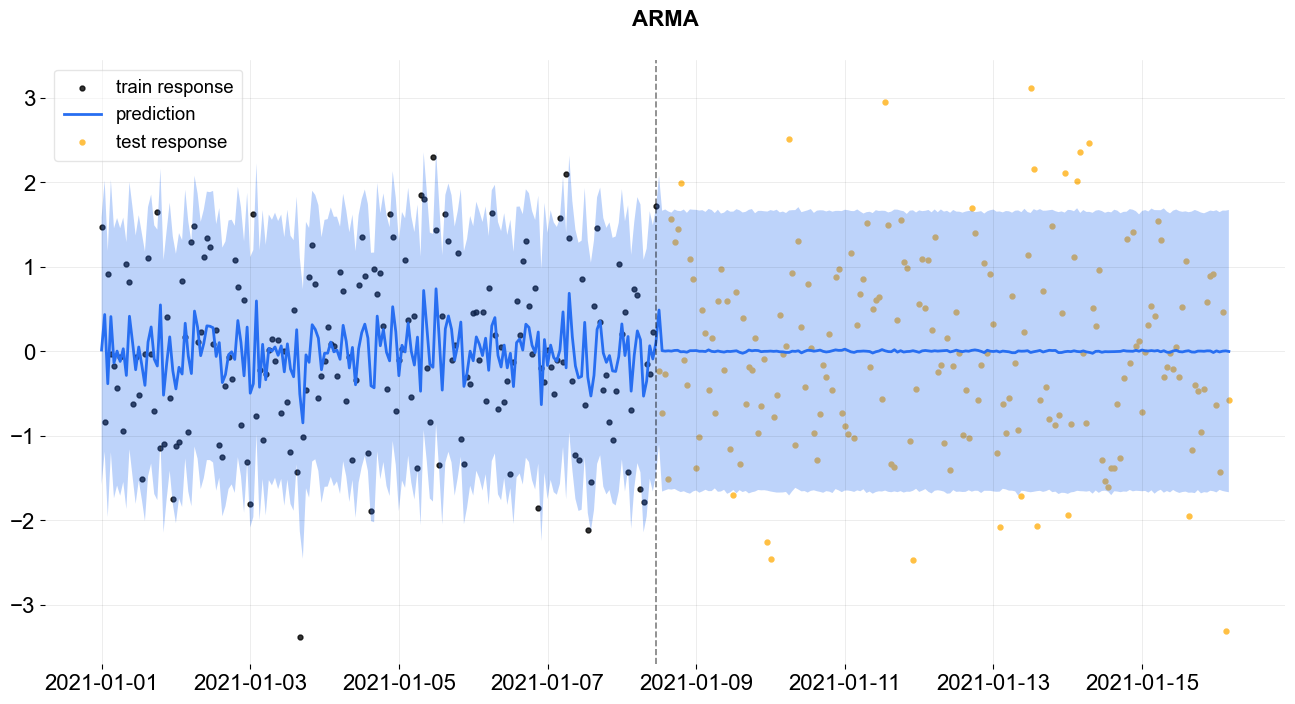

In [170]:

_ = plot_predicted_data(df_train, pred, date_col = 'hours', actual_col = 'y', title='ARMA', test_actual_df = df_test)

In [171]:
y = pd.Series(df_train['y'])
arma_mod = ARIMA(y, order=(0, 0, 1))
arma_res = arma_mod.fit()
forecast = arma_res.get_forecast(185)
yhat = forecast.predicted_mean
yhat_conf_int = forecast.conf_int(alpha=0.10)
pred['prediction_5_SM'] = yhat_conf_int['lower y']
pred['prediction_SM'] = yhat
pred['prediction_95_SM'] = yhat_conf_int['upper y']

    

In [172]:
print(arma_res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  180
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -245.464
Date:                Thu, 03 Feb 2022   AIC                            496.927
Time:                        14:08:45   BIC                            506.506
Sample:                             0   HQIC                           500.811
                                - 180                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.093     -0.010      0.992      -0.183       0.181
ma.L1          0.3110      0.065      4.799      0.000       0.184       0.438
sigma2         0.8949      0.099      9.079      0.0

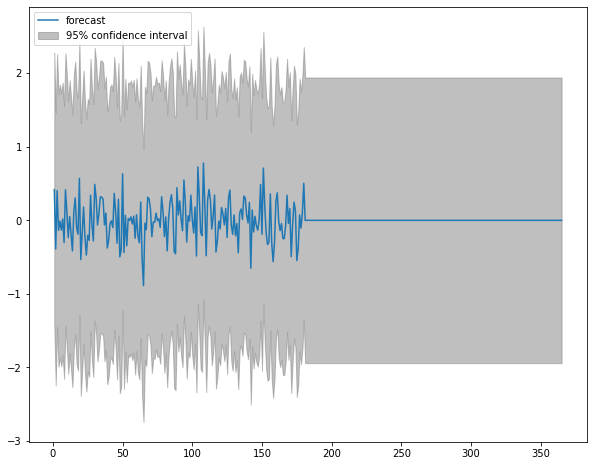

In [173]:
fig, ax = plt.subplots(figsize=(10, 8))
fig = plot_predict(arma_res, start=1, end=365, ax=ax)
legend = ax.legend(loc="upper left")

In [174]:
pred.to_csv('arma_pred_ma1.csv')

In [175]:
pred

,hours,prediction_5,prediction,prediction_95,prediction_5_SM,prediction_SM,prediction_95_SM
0,2021-01-01 00:00:00,-1.579847,0.013342,1.583858,NaN,NaN,NaN
1,2021-01-01 01:00:00,-1.188767,0.433530,2.019685,NaN,NaN,NaN
2,2021-01-01 02:00:00,-1.960963,-0.385186,1.184677,NaN,NaN,NaN
3,2021-01-01 03:00:00,-1.196287,0.409418,2.027068,NaN,NaN,NaN
4,2021-01-01 04:00:00,-1.739864,-0.139237,1.453513,NaN,NaN,NaN
...,...,...,...,...,...,...,...
360,2021-01-16 00:00:00,-1.670607,0.003495,1.667421,-1.630394,-0.000889,1.628616
361,2021-01-16 01:00:00,-1.641121,-0.009246,1.644944,-1.630394,-0.000889,1.628616
362,2021-01-16 02:00:00,-1.654238,0.000264,1.663385,-1.630394,-0.000889,1.628616
363,2021-01-16 03:00:00,-1.662415,0.003331,1.662805,-1.630394,-0.000889,1.628616


In [139]:
1.675054/1.636621

1.0234831399572655